## 1. Import Packages

In [89]:
import numpy as np
import time
import pickle
import pandas as pd
from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import sklearn.metrics as metrics

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import classification_report,roc_curve,auc, f1_score, plot_roc_curve
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import plotly.graph_objects as go
import modules.processor as Processor
import modules.utils as Utils
import modules.model as Model
import modules.model1 as Model1
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from tqdm import tqdm
from IPython.display import display

## 2. Load sub dataset

In [ ]:
train = pd.read_csv("../data/split_data/without_mhc/train/train.csv")
# train

In [ ]:
test01 = pd.read_csv("../data/split_data/without_mhc/test/test01.csv")
# test01

In [ ]:
def split_dataframe_by_position(df, splits):
    """
    Takes a dataframe and an integer of the number of splits to create.
    Returns a list of dataframes.
    """
    dataframes = []
    index_to_split = len(df) // splits
    start = 0
    end = index_to_split
    for split in range(splits):
        temporary_df = df.iloc[start:end, :]
        dataframes.append(temporary_df)
        start += index_to_split
        end += index_to_split
    return dataframes

sp_data = split_dataframe_by_position(train, 2)
# sp_data[1]

## 3. Split train data

In [ ]:
X_train = train.iloc[:, :2]
y_train = train.iloc[:, 2:]
# X_train.shape, y_train.shape

In [ ]:
X_test01 = test01.iloc[:, :2]
y_test01 = test01.iloc[:, 2:]
# X_test01.shape, y_test01.shape

## 4. NearMiss for Imbalanced Classification

In [ ]:
clf_sm = RandomUnderSampler(random_state=42)
X_res, y_res = clf_sm.fit_resample(X_train, y_train)

## 5. Data Representation: Onehot encoding

### 5.1 Without MHC

In [ ]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def one_hot_encode(seq):
    o = list(set(codes) - set(seq))
    s = pd.DataFrame(list(seq))    
    x = pd.DataFrame(np.zeros((len(seq),len(o)),dtype=int),columns=o)    
    a = s[0].str.get_dummies(sep=',')
    a = a.join(x)
    a = a.sort_index(axis=1)
    # show_matrix(a)
    e = a.values.flatten()
    return e

In [ ]:
def data_representation(X_data):
    seq_cdr3_lst = X_data['CDR3b'].to_list()
    seq_epitope_lst = X_data['epitope'].to_list()
    
    lst1 = []
    for seq in seq_cdr3_lst:
        e=one_hot_encode(seq)
        m_cdr3 = np.reshape(e, (-1, 20))
        padding = 19 - len(m_cdr3)
        c = np.concatenate((m_cdr3, np.zeros(padding * 20).reshape(padding, 20)), axis=0)
        lst1.append(c)

    lst2 = []
    for seq in seq_epitope_lst:
        e=one_hot_encode(seq)
        m_epitope = np.reshape(e, (-1, 20))
        padding = 11 - len(m_epitope)
        c = np.concatenate((m_epitope, np.zeros(padding * 20).reshape(padding, 20)), axis=0)
        lst2.append(c)
        
    res1 = list(map(lambda x: lst1[x].flatten(), range(len(lst1)))) 
    res2 = list(map(lambda x: lst2[x].flatten(), range(len(lst2))))
    
    df_res1 = pd.DataFrame(res1)
    df_res2 = pd.DataFrame(res2)
    result = pd.concat([df_res1, df_res2], axis=1)
    
    return result

### 5.2 With MHC

In [94]:
def data_representation_mhc(X_data):
    seq_cdr3_lst = X_data['CDR3b'].to_list()
    seq_epitope_lst = X_data['epitope'].to_list()
    seq_mhc_lst = X_data['MHC'].to_list()
    
    lst1 = []
    for seq in seq_cdr3_lst:
        e=Processor.one_hot_encode(seq)
        m_cdr3 = np.reshape(e, (-1, 20))
        padding = 19 - len(m_cdr3)
        c = np.concatenate((m_cdr3, np.zeros(padding * 20).reshape(padding, 20)), axis=0)
        lst1.append(c)

    lst2 = []
    for seq in seq_epitope_lst:
        e=Processor.one_hot_encode(seq)
        m_epitope = np.reshape(e, (-1, 20))
        padding = 11 - len(m_epitope)
        c = np.concatenate((m_epitope, np.zeros(padding * 20).reshape(padding, 20)), axis=0)
        lst2.append(c)
    
    lst3 = []
    for seq in seq_mhc_lst:
        e=Processor.one_hot_encode(seq)
        m_mhc = np.reshape(e, (-1, 20))
        padding = 366 - len(m_mhc)
        c = np.concatenate((m_mhc, np.zeros(padding * 20).reshape(padding, 20)), axis=0)
        lst3.append(c)

    res1 = list(map(lambda x: lst1[x].flatten(), range(len(lst1)))) 
    res2 = list(map(lambda x: lst2[x].flatten(), range(len(lst2))))
    res3 = list(map(lambda x: lst3[x].flatten(), range(len(lst3))))
    
    df_res1 = pd.DataFrame(res1)
    df_res2 = pd.DataFrame(res2)
    df_res3 = pd.DataFrame(res3)
    result = pd.concat([df_res1, df_res2, df_res3], axis=1)
    
    return result

In [ ]:
pX_res = data_representation(X_res)
py_res = y_res.copy()

pX_res.to_csv("../data/convert_data/without_mhc/res/X.csv", index=False)
py_res.to_csv("../data/convert_data/without_mhc/res/y.csv", index=False)

In [41]:
pX_res = pd.read_csv("../data/convert_data/without_mhc/res/X.csv")
py_res = pd.read_csv("../data/convert_data/without_mhc/res/y.csv")

In [ ]:
pX_test01 = data_representation(X_test01)
py_test01 = y_test01.copy()

pX_test01.to_csv("../data/converted_data/without_mhc/test/pX_test01.csv", index=False)
py_test01.to_csv("../data/converted_data/without_mhc/test/py_test01.csv", index=False)

In [125]:
pX_test01 = pd.read_csv("../data/convert_data/without_mhc/test/test01/X.csv")
py_test01 = pd.read_csv("../data/convert_data/without_mhc/test/test01/y.csv")

In [126]:
pX_test01

,0,1,2,3,4,5,6,7,8,9,...,210.1,211.1,212.1,213.1,214.1,215.1,216.1,217.1,218.1,219.1
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72903,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72904,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72905,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72906,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6. ML model: Random Forest algorithm 

In [48]:
lst_models = [
    ('Random Forest', RandomForestClassifier(random_state=42, n_jobs=-1)),
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [78]:
original_models = Model.train(lst_models, pX_res, np.ravel(py_res), cv)

	Model Random Forest has been trained in 9.95 seconds


In [76]:
lst_tunning_models = [
    ('Random Forest', RandomForestClassifier(random_state=42, n_jobs=-1), {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ["auto", "sqrt", "log2", 5, 10, 15, 20],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}),
]

In [ ]:
lst_tunning_models = Model.trainTunningModel(lst_models, pX_res, np.ravel(py_res), cv)

In [127]:
lst_tunning_models = [
    ('Random Forest', RandomForestClassifier(bootstrap=False, max_depth=90, max_features=5,
                         n_estimators=400, n_jobs=-1, random_state=42))]

lst_tunning_models_mhc = [
    ('Random Forest',RandomForestClassifier(bootstrap=False, max_depth=90, max_features='auto',
                         min_samples_split=10, n_estimators=600, n_jobs=-1, random_state=42))]

In [ ]:
best_models = Model.evaluation(lst_tunning_models, pX_res, np.ravel(py_res), pX_test01, py_test01)
best_models_mhc = Model.evaluation(lst_tunning_models_mhc, pX_res, np.ravel(py_res), pX_test01, py_test01)

In [55]:
def evaluationGroupedBarChart(pdata, phead=5):
    fig = go.Figure()
    pdata = pdata.head(phead)
    x_labels = [f'{x}' for x in (pdata['model'])]

    fig.add_trace(go.Bar(x=x_labels, y=pdata['train_acc']*100, name='Train Acc'))
    fig.add_trace(go.Bar(x=x_labels, y=pdata['test_acc']*100, name='Test Acc'))
    fig.add_trace(go.Bar(x=x_labels, y=pdata['train_roc_auc']*100, name='Train ROC-AUC'))
    fig.add_trace(go.Bar(x=x_labels, y=pdata['test_roc_auc']*100, name='Test ROC-AUC'))

    fig.show()

In [57]:
# evaluationGroupedBarChart(original_models, 7)

## 7. Predict model

In [69]:
class TCRmlModel():
    def __init__(self, pmodel, pX, py):
        self.model = pmodel
        self.model.fit(pX, py)
    
    def predict(self, pnew_data):
        yhat_class = self.model.predict(pnew_data)
        return yhat_class 

    
    def info(self):
        print(self.model)
    
    def rocAuc(self, X, y_true):
        plot_roc_curve(self.model, X, y_true)
        plt.show()
    
    def predict_proba(self, pnew_data):
        yhat_class = self.model.predict_proba(pnew_data)
        return yhat_class 

In [128]:
rf_tcr = lst_tunning_models[0][1]
model_rf = TCRmlModel(rf_tcr, pX_res, np.ravel(py_res))
model_rf.info()

RandomForestClassifier(bootstrap=False, max_depth=90, max_features=5,
                       n_estimators=400, n_jobs=-1, random_state=42)


In [129]:
y_rf_test01_proba = model_rf.predict_proba(pX_test01)
df_test01 = pd.DataFrame(data = y_rf_test01_proba, columns = ["tmp", "predict_proba"])

In [130]:
df_test = df_test01.iloc[:, 1:]
df_prob_test01 = pd.concat([test01, df_test01], axis=1)
df_prob_test01['binder_pred'] = np.where(df_prob_test01['predict_proba'] >= 0.5, 1, 0)

df_prob_test01.to_csv("../data/predict_data/test01_predict_proba.csv", index=False)

In [136]:
y_test01 = df_prob_test01["binder"].to_numpy()
y_test01_pred = df_prob_test01["binder_pred"].to_numpy()

In [137]:
def confusionMatrix(y_true, y_pred):
    target_names = ['Non-binder', 'Binder']
    print(classification_report(y_true, y_pred, target_names=target_names))
    cm = pd.DataFrame(confusion_matrix(y_true, y_pred), index=target_names, columns=target_names)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion matrix')
    plt.xlabel('Predicted values')
    plt.ylabel('Actual values')
    plt.show()

              precision    recall  f1-score   support

  Non-binder       0.99      0.90      0.95     66280
      Binder       0.49      0.94      0.64      6628

    accuracy                           0.91     72908
   macro avg       0.74      0.92      0.80     72908
weighted avg       0.95      0.91      0.92     72908



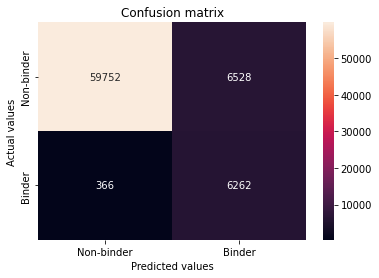

In [144]:
confusionMatrix(y_test01, y_test01_pred)
tn, fp, fn, tp = confusion_matrix(y_test01, y_test01_pred).ravel()
# print('Sensitivity (TPR): ', tp/(tp+fn))
# print('Specificity (TNR): ', tn/(tn+fp))

In [139]:
def model_run(algo, pX_res, py_res, pX_test, py_test):

    algo.fit(pX_res, np.ravel(py_res))
    y_pred = algo.predict(pX_test)
    y_pred_proba = algo.predict_proba(pX_test)[:,1]
    
    accuracy = accuracy_score(py_test, y_pred).ravel()
    classify_metrics = classification_report(py_test, y_pred)
    f1 = f1_score(py_test, y_pred).ravel()
    
    fpr, tpr, thresholds = roc_curve(py_test, y_pred_proba)
    auc_score = auc(fpr, tpr)
    tn, fp, fn, tp = confusion_matrix(py_test, y_pred).ravel()
    confusionMatrix(py_test, y_pred)
    
    print (algo)
    print ("Accuracy score        : ", accuracy)
    print ("F1 score              : ", f1)
    print ("AUC                   : ", auc_score)
    print ('Sensitivity (TPR)     : ', tp/(tp+fn))
    print ('Specificity (TNR)     : ', tn/(tn+fp))
    print ("classification report :\n", classify_metrics)
    
    return accuracy, classify_metrics, fpr , tpr, auc_score, f1


              precision    recall  f1-score   support

  Non-binder       0.99      0.90      0.95     66280
      Binder       0.49      0.94      0.64      6628

    accuracy                           0.91     72908
   macro avg       0.74      0.92      0.80     72908
weighted avg       0.95      0.91      0.92     72908



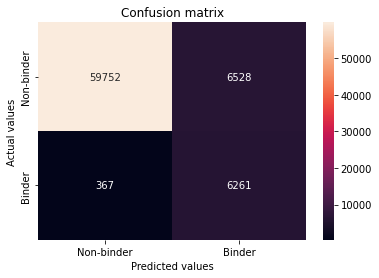

RandomForestClassifier(bootstrap=False, max_depth=90, max_features=5,
                       n_estimators=400, n_jobs=-1, random_state=42)
Accuracy score        :  [0.90542876]
F1 score              :  [0.6448988]
AUC                   :  0.977335742159686
Sensitivity (TPR)     :  0.9446288473144236
Specificity (TNR)     :  0.9015087507543754
classification report :
               precision    recall  f1-score   support

           0       0.99      0.90      0.95     66280
           1       0.49      0.94      0.64      6628

    accuracy                           0.91     72908
   macro avg       0.74      0.92      0.80     72908
weighted avg       0.95      0.91      0.92     72908



In [140]:
accuracy_rf_test01, classify_metrics_rf_test01, fpr_rf_test01, tpr_rf_test01_loc, auc_score_rf_test01, f1_rf_test01 = model_run(rf_tcr, pX_res, py_res, pX_test01, py_test01)

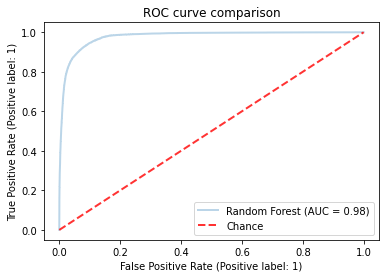

In [141]:
from sklearn.metrics import plot_roc_curve

ax = plt.subplot()
n = pX_test01.shape[0]
mean_fpr = np.linspace(0, 1, n)
tprs = []
aucs = []
viz = plot_roc_curve(rf_tcr, pX_test01, py_test01,
                         name='Random Forest',
                         alpha=.3, lw=2, ax=ax)
interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
interp_tpr[0] = 0.0
tprs.append(interp_tpr)
aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
label='Chance', alpha=.8)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
title="ROC curve comparison")
ax.legend(loc="lower right")
plt.show()

In [142]:
def saveByPickle(object, path):
    pickle.dump(object, open(path, "wb"))
    print(f"{object} has been saved at {path}.")

In [143]:
saveByPickle(model_rf, "./models/rdforest_model.pickle")
pickled_model_rf = pickle.load(open('./models/rdforest_model.pickle', 'rb'))

<__main__.TCRmlModel object at 0x7f88c1ee0828> has been saved at ./models/rdforest_model.pickle.
